In [1]:
%pip install tensorflow keras numpy pandas matplotlib scikit-learn keras-tuner building_footprint_segmentation

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Balancing classes to have 201 images each.
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 1407
Training images: 1125
Temp images (for validation and testing): 282
Validation images: 141
Test images: 141

Dataset: Training set
Class: Commercial, Number of images: 161
Class: High, Number of images: 161
Class: Hospital, Number of images: 161
Class: Industrial, Number of images: 160
Class: Multi, Number of images: 161
Class: Schools, Number of images: 161
Class: Single, Numb

Model saved at /content/drive/MyDrive/Densenet201_combined_2.h5.


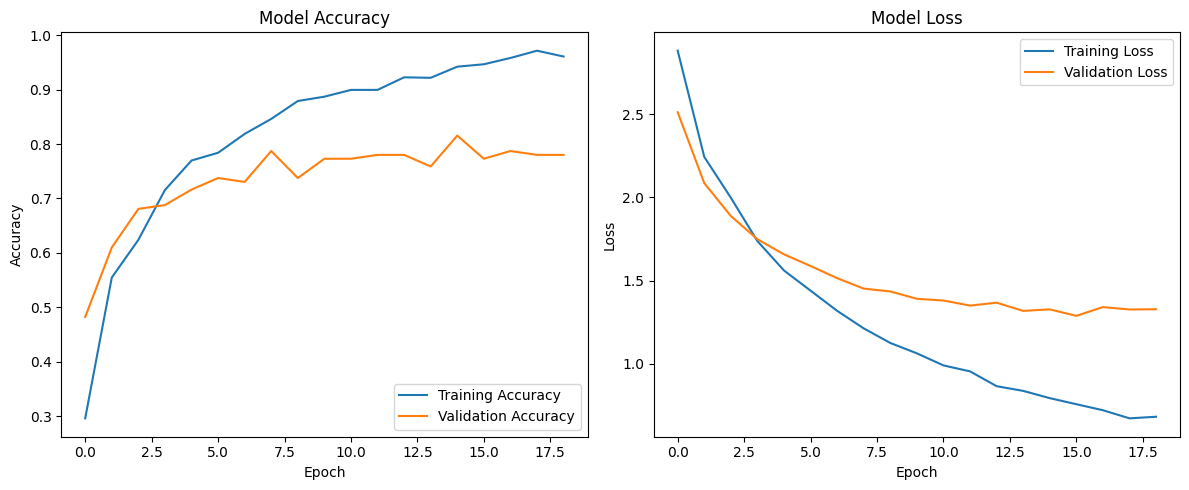

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8302 - loss: 1.0742 
Test Accuracy: 83.6879%
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step
Confusion Matrix:
 [[13  1  0  0  5  1  0]
 [ 1 18  0  1  0  0  0]
 [ 0  0 19  0  0  1  0]
 [ 0  1  0 18  1  1  0]
 [ 4  0  0  0 15  0  1]
 [ 0  1  1  1  1 16  0]
 [ 0  1  0  0  0  0 19]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.72      0.65      0.68        20
        High       0.82      0.90      0.86        20
    Hospital       0.95      0.95      0.95        20
  Industrial       0.90      0.86      0.88        21
       Multi       0.68      0.75      0.71        20
     Schools       0.84      0.80      0.82        20
      Single       0.95      0.95      0.95        20

    accuracy                           0.84       141
   macro avg       0.84      0.84      0.84       141
weighted avg       0.84      0.84      0.84       141


Final Test Accuracy: 83.6879%


In [8]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split  # Added for data splitting


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/Abduls RA Work Folder/SAT_Images/Data Collection/'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    # Use automatic mixed precision without LossScaleOptimizer
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model without LossScaleOptimizer
    optimizer = Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

def balance_dataset(image_paths, labels):
    from collections import defaultdict
    random.seed(42)  # For reproducibility

    # Group image paths by class label
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)

    # Find the minimum number of images in any class
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")

    # For each class, randomly sample min_count images
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)

    return balanced_image_paths, balanced_labels

def shuffle_data(paths, labels):
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths[:], labels[:] = zip(*combined)
    return list(paths), list(labels)

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data per class
    from collections import defaultdict

    class_to_images = defaultdict(list)
    for img_path, label in zip(all_image_paths, all_labels):
        class_to_images[label].append(img_path)

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []
    test_paths, test_labels = [], []

    for label, images in class_to_images.items():
        np.random.shuffle(images)
        n_total = len(images)
        n_train = int(0.8 * n_total)
        n_val = int(0.1 * n_total)
        n_test = n_total - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        train_paths.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))

        val_paths.extend(val_imgs)
        val_labels.extend([label] * len(val_imgs))

        test_paths.extend(test_imgs)
        test_labels.extend([label] * len(test_imgs))

    # Shuffle the datasets
    train_paths, train_labels = shuffle_data(train_paths, train_labels)
    val_paths, val_labels = shuffle_data(val_paths, val_labels)
    test_paths, test_labels = shuffle_data(test_paths, test_labels)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_2.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 1536
Training images: 1228
Temp images (for validation and testing): 308
Validation images: 154
Test images: 154

Dataset: Training set
Class: Commercial, Number of images: 162
Class: High, Number of images: 233
Class: Hospital, Number of images: 161
Class: Industrial, Number of images: 172
Class: Multi, Number of images: 173
Class: Schools, Number of images: 163
Class: Single, Number of images: 164



Dataset: Validation set
Class: Com

Model saved at /content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_5.h5.


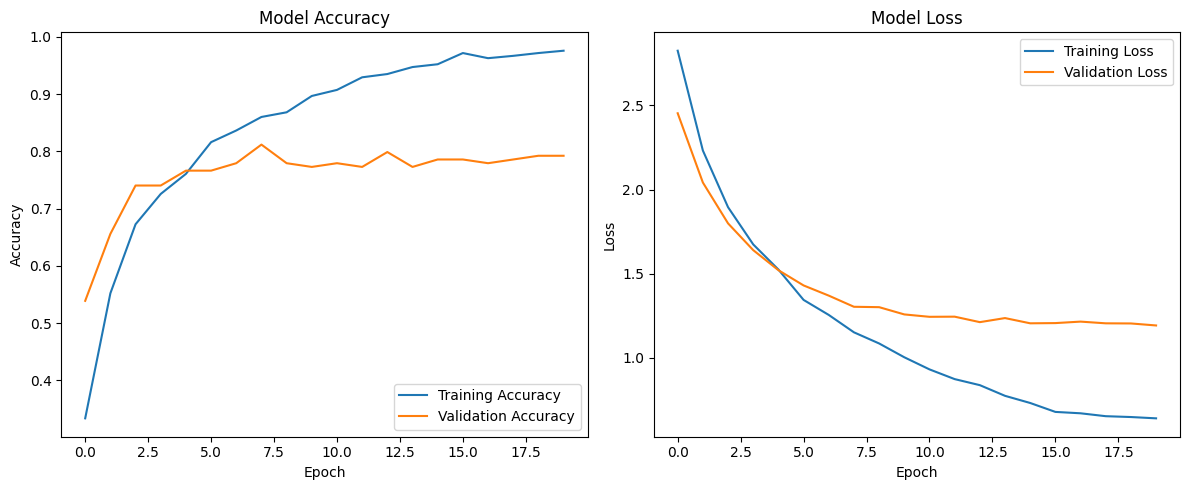

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.8374 - loss: 0.9586
Test Accuracy: 83.1169%
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step
Confusion Matrix:
 [[14  0  0  2  4  0  0]
 [ 0 28  0  1  1  0  0]
 [ 0  0 18  0  0  2  0]
 [ 1  0  0 19  0  1  0]
 [ 4  0  1  0 13  1  3]
 [ 0  0  3  0  1 16  0]
 [ 0  0  0  0  1  0 20]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.74      0.70      0.72        20
        High       1.00      0.93      0.97        30
    Hospital       0.82      0.90      0.86        20
  Industrial       0.86      0.90      0.88        21
       Multi       0.65      0.59      0.62        22
     Schools       0.80      0.80      0.80        20
      Single       0.87      0.95      0.91        21

    accuracy                           0.83       154
   macro avg       0.82      0.83      0.82       154
weighted avg       0.83      0.83      0.83       154


Final Test Accuracy: 83.1169%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  # Added for data splitting
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history
import logging  # Added for logging

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(img_path)
                    labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        raise tf.errors.InvalidArgumentError(None, None, f"Error loading image {filename}")

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_5.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/ML/Model/train': ['Commercial', 'Hospital', 'High', 'Industrial', 'Schools', 'Single', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 560
Training images: 448
Temp images (for validation and testing): 112
Validation images: 56
Test images: 56

Dataset: Training set
Class: Commercial, Number of images: 64
Class: High, Number of images: 64
Class: Hospital, Number of images: 64
Class: Industrial, Number of images: 64
Class: Multi, Number of images: 64
Class: Schools, Number of images: 64
Class: Single, Number of images: 64



Dataset: Validation set
Class: Commercial, Number of images: 8
Class: High, Number of images: 8
C

Model saved at /content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_5.h5.


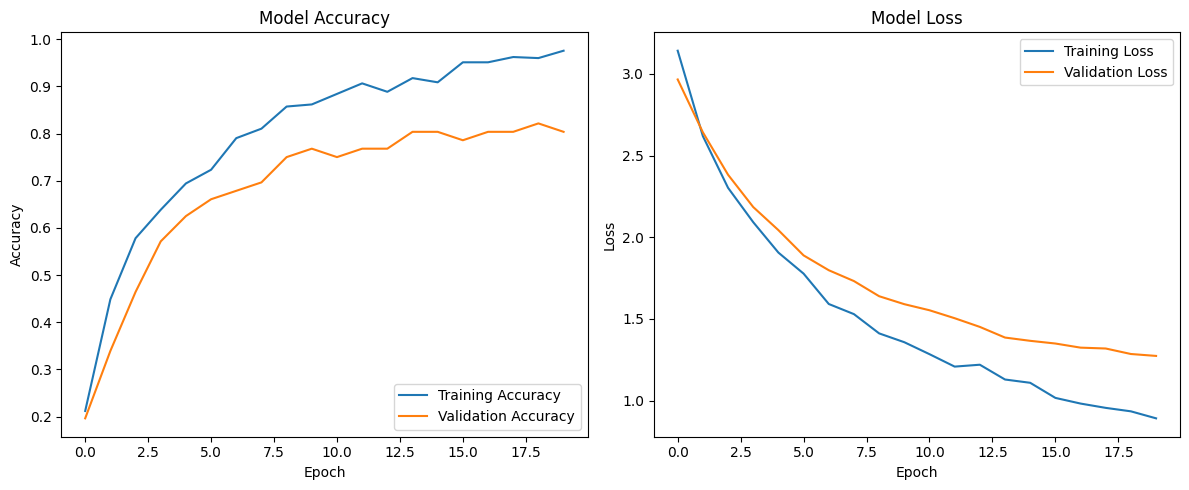

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.7753 - loss: 1.2548
Test Accuracy: 80.3571%
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 17s/step
Confusion Matrix:
 [[5 0 0 0 3 0 0]
 [0 8 0 0 0 0 0]
 [1 0 6 0 0 1 0]
 [0 0 0 8 0 0 0]
 [0 0 0 0 6 1 1]
 [2 0 0 1 1 4 0]
 [0 0 0 0 0 0 8]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.62      0.62      0.62         8
        High       1.00      1.00      1.00         8
    Hospital       1.00      0.75      0.86         8
  Industrial       0.89      1.00      0.94         8
       Multi       0.60      0.75      0.67         8
     Schools       0.67      0.50      0.57         8
      Single       0.89      1.00      0.94         8

    accuracy                           0.80        56
   macro avg       0.81      0.80      0.80        56
weighted avg       0.81      0.80      0.80        56


Final Test Accuracy: 80.3571%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  # Added for data splitting
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history
import logging  # Added for logging

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(img_path)
                    labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_combined_5.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")
